In [37]:
import networkx as nx
import random
import time
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

In [38]:
# Função para gerar um grafo com pesos aleatórios
def gerar_grafo_aleatorio(n, p):
    G = nx.gnp_random_graph(n, p)
    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(10, 500)
    return G

In [39]:
# Função para ler as instâncias do problema
def ler_instancia(caminho_arquivo):
    with open(caminho_arquivo, 'r') as f:
        # Ler a primeira linha (n, nc, m)
        primeira_linha = f.readline().strip().split()
        n = int(primeira_linha[0])
        nc = int(primeira_linha[1])
        m = int(primeira_linha[2])
        
        # Inicializar o grafo
        G = nx.Graph()
        
        # Ler os vértices centrais e seus graus mínimos
        centrais = {}
        for _ in range(nc):
            linha = f.readline().strip().split()
            vertice_central = int(linha[0])
            grau_minimo = int(linha[1])
            centrais[vertice_central] = grau_minimo
        
        # Ler as arestas e os custos
        for _ in range(m):
            linha = f.readline().strip().split()
            i = int(linha[0])
            j = int(linha[1])
            custo = int(linha[2])
            G.add_edge(i, j, weight=custo)
        
        nx.draw(G, with_labels=True)    
    return G, centrais

In [40]:
# Função de Eliminação de Ciclos
def eliminacao_ciclos(G, centrais):
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Variáveis de decisão: 1 se a aresta for selecionada, 0 caso contrário
    x = {}
    for u, v in G.edges():
        x[(min(u, v), max(u, v))] = solver.BoolVar(f'x_{u}_{v}')

    # Função objetivo: minimizar o custo total das arestas selecionadas
    solver.Minimize(solver.Sum(G[u][v]['weight'] * x[(min(u, v), max(u, v))] for u, v in G.edges()))

    # Restrições de conectividade (Eliminação de Ciclos)
    for subset in nx.connected_components(G):
        if len(subset) > 1:
            edges_in_subset = [(min(u, v), max(u, v)) for u, v in G.edges() if u in subset and v in subset]
            solver.Add(solver.Sum(x[(u, v)] for u, v in edges_in_subset) <= len(subset) - 1)

    # Restrições de grau mínimo para os vértices centrais
    for v, grau_minimo in centrais.items():
        solver.Add(solver.Sum(x[(min(u, v), max(u, v))] for u, v in G.edges(v)) >= grau_minimo)

    # Definir limite de tempo de execução
    solver.SetTimeLimit(1800000)  # 30 minutos em milissegundos

    # Resolver o problema
    start_time = time.time()
    status = solver.Solve()
    end_time = time.time()

    if status == pywraplp.Solver.OPTIMAL:
        print("Solução ótima encontrada.")
    else:
        print("Solução não encontrada ou tempo limite excedido.")
    
    return end_time - start_time


In [41]:
# Função de Rótulos nos Vértices
def rotulos_vertices(G, centrais):
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Variáveis de decisão: 1 se o arco (i, j) estiver na árvore, 0 caso contrário
    y = {}
    for u, v in G.edges():
        y[(min(u, v), max(u, v))] = solver.BoolVar(f'y_{u}_{v}')

    # Função objetivo: minimizar o custo total das arestas selecionadas
    solver.Minimize(solver.Sum(G[u][v]['weight'] * y[(min(u, v), max(u, v))] for u, v in G.edges()))

    # Restrições de conectividade e rótulos
    root = 0  # Escolher um vértice raiz arbitrário
    labels = {}
    for v in G.nodes():
        labels[v] = solver.IntVar(1, len(G.nodes()), f'label_{v}')
    
    for u, v in G.edges():
        solver.Add(labels[min(u, v)] - labels[max(u, v)] + len(G.nodes()) * y[(min(u, v), max(u, v))] <= len(G.nodes()) - 1)

    # Restrições de grau mínimo para os vértices centrais
    for v, grau_minimo in centrais.items():
        solver.Add(solver.Sum(y[(min(u, v), max(u, v))] for u, v in G.edges(v)) >= grau_minimo)

    # Definir limite de tempo de execução
    solver.SetTimeLimit(1800000)  # 30 minutos em milissegundos

    # Resolver o problema
    start_time = time.time()
    status = solver.Solve()
    end_time = time.time()

    if status == pywraplp.Solver.OPTIMAL:
        print("Solução ótima encontrada.")
    else:
        print("Solução não encontrada ou tempo limite excedido.")

    return end_time - start_time


In [42]:
def comparar_formulacoes(caminho_arquivo):
    # Ler a instância
    G, centrais = ler_instancia(caminho_arquivo)
    
    print(f"Comparando formulações para instância {caminho_arquivo}")
    
    # Eliminação de Ciclos
    tempo_eliminacao_ciclos = eliminacao_ciclos(G, centrais)
    print(f"Tempo Eliminação de Ciclos: {tempo_eliminacao_ciclos:.2f} segundos")
    
    # Rótulos nos Vértices
    tempo_rotulos_vertices = rotulos_vertices(G, centrais)
    print(f"Tempo Rótulos nos Vértices: {tempo_rotulos_vertices:.2f} segundos")


Path para a instância:  instancias/tb8ch4_0.txt
Comparando formulações para instância instancias/tb8ch4_0.txt
Solução ótima encontrada.
Tempo Eliminação de Ciclos: 0.00 segundos
Solução ótima encontrada.
Tempo Rótulos nos Vértices: 0.00 segundos


Path para a instância:  instancias/tb8ch4_1.txt
Comparando formulações para instância instancias/tb8ch4_1.txt
Solução ótima encontrada.
Tempo Eliminação de Ciclos: 0.00 segundos
Solução ótima encontrada.
Tempo Rótulos nos Vértices: 0.00 segundos


Path para a instância:  instancias/tb8ch8_0.txt
Comparando formulações para instância instancias/tb8ch8_0.txt
Solução ótima encontrada.
Tempo Eliminação de Ciclos: 0.00 segundos
Solução ótima encontrada.
Tempo Rótulos nos Vértices: 0.00 segundos


Path para a instância:  instancias/tb8ch8_1.txt
Comparando formulações para instância instancias/tb8ch8_1.txt
Solução ótima encontrada.
Tempo Eliminação de Ciclos: 0.00 segundos
Solução ótima encontrada.
Tempo Rótulos nos Vértices: 0.00 segundos


Path par

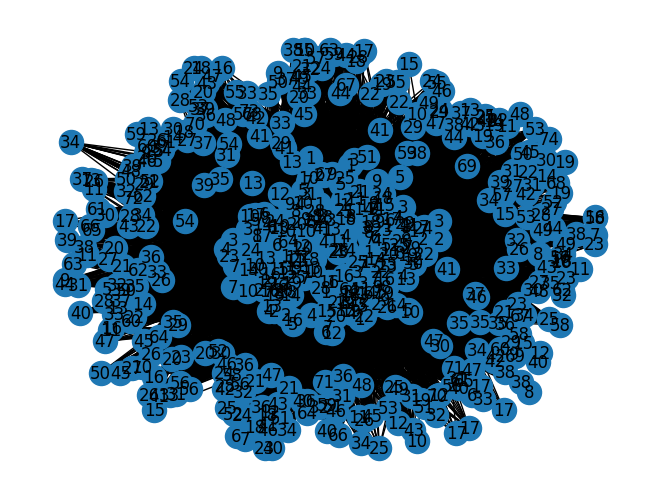

In [43]:
# Exemplo de uso com as instâncias
instancias = [
    'instancias/tb8ch4_0.txt',
    'instancias/tb8ch4_1.txt',
    'instancias/tb8ch8_0.txt',
    'instancias/tb8ch8_1.txt',
    'instancias/tb8ch10_0.txt',
    'instancias/tb8ch10_1.txt',
    'instancias/tb8ch15_0.txt',
    'instancias/tb8ch15_1.txt',
    'instancias/tb8ch20_0.txt',
    'instancias/tb8ch20_1.txt',
    'instancias/tb8ch25_0.txt',
    'instancias/tb8ch25_1.txt',
    'instancias/tb8ch30_0.txt',
    'instancias/tb8ch30_1.txt'
]

for instancia in instancias:
    print("Path para a instância: ", instancia)
    comparar_formulacoes(instancia)
    print("\n")
